<a href="https://colab.research.google.com/github/dishant26/Google-Dino-Game-using-Opencv-Tensorflow/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg
import pandas as pd
import zipfile
import random
import shutil
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from shutil import copyfile
from os import getcwd
from zipfile import ZipFile

In [2]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
# The shareable link
id = '1SIVcfWQjaSKpmmYiv1_hKcY83cDlrPDI'
print (id) # Verify that you have everything after '='

1SIVcfWQjaSKpmmYiv1_hKcY83cDlrPDI


In [4]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Dataset.zip')

In [5]:
file_name = "Dataset.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print("Done")

Done


In [6]:
!pwd

/content


In [7]:
try:
    os.mkdir('/content/fist-v-palm')
    os.mkdir('/content/fist-v-palm/training')
    os.mkdir('/content/fist-v-palm/testing')
    os.mkdir('/content/fist-v-palm/validation')
    os.mkdir('/content/fist-v-palm/training/fist')
    os.mkdir('/content/fist-v-palm/training/palm')
    os.mkdir('/content/fist-v-palm/testing/fist')
    os.mkdir('/content/fist-v-palm/testing/palm')
    os.mkdir('/content/fist-v-palm/validation/fist')
    os.mkdir('/content/fist-v-palm/validation/palm')
except OSError:
    pass

In [8]:
FistTrain_SOURCE = '/content/Dataset/FistImages/'
PalmTrain_SOURCE = '/content/Dataset/PalmImages/'
FistTest_SOURCE = '/content/Dataset/FistTest/'
PalmTest_SOURCE = '/content/Dataset/PalmTest/'

In [9]:
print(len(os.listdir(FistTrain_SOURCE)))
print(len(os.listdir(PalmTrain_SOURCE)))
print(len(os.listdir(FistTest_SOURCE)))
print(len(os.listdir(PalmTest_SOURCE)))

1000
1000
100
100


In [10]:
TRAINING_FIST_DIR = '/content/fist-v-palm/training/fist/'
TRAINING_PALM_DIR = '/content/fist-v-palm/training/palm/'
TESTING_FIST_DIR = '/content/fist-v-palm/testing/fist/'
TESTING_PALM_DIR = '/content/fist-v-palm/testing/palm/'
VALIDATION_FIST_DIR = '/content/fist-v-palm/validation/fist/'
VALIDATION_PALM_DIR = '/content/fist-v-palm/validation/palm/'

TRAINING_DIR = '/content/fist-v-palm/training/'
TESTING_DIR = '/content/fist-v-palm/testing/'
VALIDATION_DIR = '/content/fist-v-palm/validation/'

In [11]:
def create_train_val(SOURCE, TRAINING, VALIDATION):
    
  files = []
  for filename in os.listdir(SOURCE):
      file = SOURCE + filename
      if os.path.getsize(file) > 0:
          files.append(filename)
      else:
          print(filename + " is zero length, so ignoring.")
  
  training_length = int(len(files) * 0.9)
  validation_length = int(len(files) - training_length)
  shuffled_set = random.sample(files, len(files))
  training_set = shuffled_set[0: training_length]
  validation_set = shuffled_set[-validation_length:]


  for filename in training_set:
      source = SOURCE + filename
      destination = TRAINING + filename
      copyfile(source, destination)

  for filename in validation_set:
      source = SOURCE + filename
      destination = VALIDATION + filename
      copyfile(source, destination)

create_train_val(FistTrain_SOURCE, TRAINING_FIST_DIR, VALIDATION_FIST_DIR)
create_train_val(PalmTrain_SOURCE, TRAINING_PALM_DIR, VALIDATION_PALM_DIR)

In [12]:
def create_test(SOURCE, TESTING):
    
  testing_set = []
  for filename in os.listdir(SOURCE):
      file = SOURCE + filename
      if os.path.getsize(file) > 0:
          testing_set.append(filename)
      else:
          print(filename + " is zero length, so ignoring.")
  
  testing_length = int(len(testing_set))
  
  for filename in testing_set:
      source = SOURCE + filename
      destination = TESTING + filename
      copyfile(source, destination)

create_test(FistTest_SOURCE, TESTING_FIST_DIR)
create_test(PalmTest_SOURCE, TESTING_PALM_DIR)

In [13]:
print(len(os.listdir(TRAINING_DIR)))
print(len(os.listdir(TESTING_DIR)))
print(len(os.listdir(TRAINING_FIST_DIR)))
print(len(os.listdir(TRAINING_PALM_DIR)))
print(len(os.listdir(TESTING_FIST_DIR)))
print(len(os.listdir(TESTING_PALM_DIR)))
print(len(os.listdir(VALIDATION_PALM_DIR)))
print(len(os.listdir(VALIDATION_FIST_DIR)))

2
2
900
900
100
100
100
100


In [14]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(89, 100, 1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')                               
])

model.compile(optimizer=RMSprop(lr=0.01), loss='binary_crossentropy', metrics=['acc'])

In [15]:
train_datagen = ImageDataGenerator( rescale = 1.0/255. )

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=128,
                                                    class_mode='binary',
                                                    color_mode = 'grayscale',
                                                    target_size=(89, 100))

validation_datagen = ImageDataGenerator( rescale = 1.0/255. )

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                         batch_size=128,
                                                         class_mode  = 'binary',
                                                         color_mode = 'grayscale',
                                                         target_size = (89, 100))


Found 1800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [16]:
my_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [17]:
history = model.fit_generator(train_generator,
                              epochs=30,
                              verbose=1,
                              callbacks = [my_callback],
                              validation_data=validation_generator
                              )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
15/15 [==============================] - 1s 57ms/step - loss: 43.3969 - acc: 0.7783 - val_loss: 0.0464 - val_acc: 0.9900
Epoch 2/30
15/15 [==============================] - 1s 42ms/step - loss: 0.0070 - acc: 0.9983 - val_loss: 0.0047 - val_acc: 1.0000
Epoch 3/30
15/15 [==============================] - 1s 41ms/step - loss: 6.8446e-04 - acc: 1.0000 - val_loss: 0.0222 - val_acc: 0.9950
Epoch 4/30
15/15 [==============================] - 1s 41ms/step - loss: 4.6972e-04 - acc: 1.0000 - val_loss: 6.5606e-04 - val_acc: 1.0000
Epoch 5/30
15/15 [==============================] - 1s 42ms/step - loss: 4.7919e-05 - acc: 1.0000 - val_loss: 3.5153e-04 - val_acc: 1.0000
Epoch 6/30
15/15 [==============================] - 1s 42ms/step - loss: 2.2019e-05 - acc: 1.0000 - val_loss: 2.6825e-04 - val_acc: 1.0000
Epoch 7/30
15/15 [==============================] - 1s 41ms/step - loss: 4.8570e-05 - acc: 1.0000 - val_loss:

Text(0.5, 1.0, 'Training and validation loss')

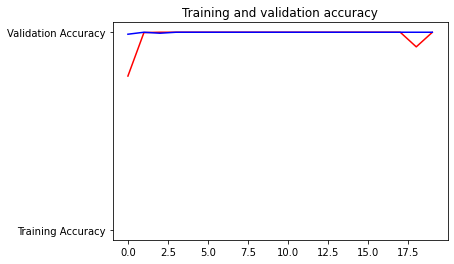

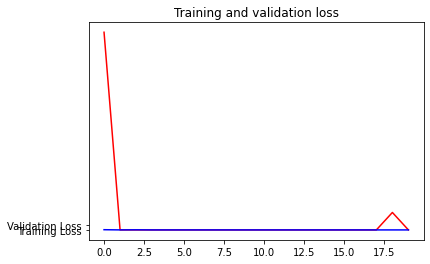

In [18]:
%matplotlib inline

acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')


In [20]:
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

test_generator = test_datagen.flow_from_directory(TESTING_DIR,
                                                    batch_size=1,
                                                    class_mode='binary',
                                                  color_mode = 'grayscale',
                                                    target_size=(89, 100))

filenames = test_generator.filenames
nb_samples = len(filenames)

loss, acc = model.evaluate_generator(test_generator, steps=1, verbose=0)

Found 200 images belonging to 2 classes.


In [21]:
print(loss)
print(acc)

8.093377914519806e-07
1.0


In [ ]:
model.save("my_model.h5")